# Neural Machine Translation

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-11.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a [Neural Machine Translation (NMT)](https://en.wikipedia.org/wiki/Neural_machine_translation) model to translate human-readable dates into machine-readable dates.

The network will input a date written in a variety of possible formats (e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987") and translate them into standardized, machine readable dates (e.g. "1958-08-29", "1968-03-30", "1987-06-24"). The model will be trained on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates and learn to output dates in the common machine-readable format YYYY-MM-DD.

## Import libraries

In [1]:
from faker import Faker
from babel.dates import format_date
import random
from tqdm import tqdm
import numpy as np
from keras import utils, layers, activations, Model
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2024-08-17 14:24:48.611034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 14:24:48.632538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 14:24:48.639334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 14:24:48.655796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [2]:
def load_date():
    """
        Loads some fake dates.
        Returns a tuple containing human readable string, machine readable string, and date object.
    """

    fake = Faker()
    dt = fake.date_object()
    
    # Define format of the data we would like to generate
    FORMATS = ['short', 'medium', 'long', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full',
                'd MMM YYY', 'd MMMM YYY', 'dd MMM YYY', 'd MMM, YYY', 'd MMMM, YYY', 'dd, MMM YYY', 'd MM YY', 'd MMMM YYY',
                'MMMM d YYY', 'MMMM d, YYY', 'dd.MM.YY']
                
    try:
        human_readable = format_date(dt, format=random.choice(FORMATS), locale='en_US')
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',', '')
        machine_readable = dt.isoformat()       
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(n):
    """
        Loads a dataset with "n" examples and vocabularies, where "n" is the number of examples to generate.
    """
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    
    for _ in tqdm(range(n)):
        h, m, _ = load_date()

        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k, v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [3]:
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(n=10000)
dataset[:10]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:31<00:00, 65.84it/s]


[('21 feb 1983', '1983-02-21'),
 ('friday january 9 1981', '1981-01-09'),
 ('29 apr 1993', '1993-04-29'),
 ('nov 17 2020', '2020-11-17'),
 ('8 december 2001', '2001-12-08'),
 ('20 february 2010', '2010-02-20'),
 ('13 jan 1987', '1987-01-13'),
 ('tuesday november 27 2007', '2007-11-27'),
 ('18 03 04', '2004-03-18'),
 ('thursday august 21 1986', '1986-08-21')]

- `dataset`: A list of tuples of (human readable date, machine readable date).
- `human_vocab`: A python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: A python dictionary mapping all characters used in machine readable dates to an integer-valued index.
- `inv_machine_vocab`: The inverse dictionary of machine_vocab, mapping from indices back to characters.

## Preprocess the data

In [4]:
def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab".
    
    Arguments:
    string -- Input string, e.g. 'Wed 10 Jul 2007'
    length -- The number of time steps, it determines if the output will be padded or cut
    vocab -- Vocabulary, dictionary used to index every character of the "string"
    
    Returns:
    rep -- List of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    # Make lower to standardize
    string = string.lower()
    string = string.replace(',', '')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    return rep

def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: utils.to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: utils.to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

In [5]:
Tx = 30 # Assume Tx is the maximum length of the human readable date
Ty = 10 # "YYYY-MM-DD" is 10 characters long
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Xoh shape:", Xoh.shape)
print("Yoh shape:", Yoh.shape)

X shape: (10000, 30)
Y shape: (10000, 10)
Xoh shape: (10000, 30, 37)
Yoh shape: (10000, 10, 11)


- `X`: A processed version of the human readable dates in the training set.
    - Each character in `X` is replaced by an index (integer) mapped to the character using `human_vocab`.
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >).
    - X.shape = (m, Tx) where m is the number of training examples in a batch.
- `Y`: A processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`.
    - Y.shape = (m, Ty).
- `Xoh`: One-hot version of `X`.
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0).
    - Xoh.shape = (m, Tx, len(human_vocab)).
- `Yoh`: One-hot version of `Y`.
    - Each index in `Y` is converted to the one-hot representation.
    - Yoh.shape = (m, Ty, len(machine_vocab)).
    - len(machine_vocab) = 11 since there are 10 numeric digits (0 to 9) and the `-` symbol.

In [6]:
index = 0

print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])

print("\nSource after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])

print("\nSource after preprocessing (one-hot):\n", Xoh[index])
print("Target after preprocessing (one-hot):\n", Yoh[index])

Source date: 21 feb 1983
Target date: 1983-02-21

Source after preprocessing (indices): [ 5  4  0 18 17 14  0  4 12 11  6 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10  9  4  0  1  3  0  3  2]

Source after preprocessing (one-hot):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot):
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Create a NMT model with attention

The [attention mechanism](https://arxiv.org/pdf/1508.04025v5) tells a NMT model where it should pay attention to at any step.

In [7]:
def softmax(x, axis=1):
    """Custom softmax activation function.
    # Arguments
        x: Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """

    ndim = x.shape.rank

    if ndim == 2:
        return activations.softmax(x)
    elif ndim > 2:
        e = tf.exp(x - tf.reduce_max(x, axis=axis, keepdims=True))
        s = tf.reduce_sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D!')

Define shared layers as global variables.

In [8]:
repeator = layers.RepeatVector(Tx) # Repeat the input n times
concatenator = layers.Concatenate(axis=-1) # Layer that concatenates a list of inputs
densor1 = layers.Dense(10, activation="tanh")
densor2 = layers.Dense(1, activation="relu")
activator = layers.Activation(softmax, name='attention_weights') # Use a custom softmax(axis=1)
dotor = layers.Dot(axes=1) # Layer that computes a dot product between samples in two tensors

In [9]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- Hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- Previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- Context vector, input of the next (post-attention) LSTM cell
    """

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that it can  be concatenated with all hidden states "a"
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies"
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies"
    energies = densor2(e)
    # Use activator on "energies" to compute the attention weights "alphas"
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas, a])
    
    return context

In [10]:
n_a = 32 # Number of units for the pre-attention, bi-directional LSTM's hidden state "a"
n_s = 64 # Number of units for the post-attention LSTM's hidden state "s"

# This is the post attention LSTM cell
post_activation_LSTM_cell = layers.LSTM(n_s, return_state=True)
output_layer = layers.Dense(len(machine_vocab), activation=softmax)

# Define the inputs of the model with a shape (Tx,)
inputs = layers.Input(shape=(Tx, len(human_vocab)))

# Define s0 (initial hidden state) and c0 (initial cell state)
# for the decoder LSTM with shape (n_s,)
s0 = layers.Input(shape=(n_s,))
c0 = layers.Input(shape=(n_s,))
s, c = s0, c0

# Initialize empty list of outputs
outputs = []

# Define the pre-attention Bi-LSTM
a = layers.Bidirectional(layers.LSTM(n_a, return_sequences=True))(inputs)

# Iterate for Ty steps
for t in range(Ty):
    # Perform one step of the attention mechanism to get back the context vector at step t
    context = one_step_attention(a, s)
    
    # Apply the post-attention LSTM cell to the "context" vector
    s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
    
    # Apply Dense layer to the hidden state output of the post-attention LSTM
    output = output_layer(s)
    
    # Append "output" to the "outputs" list
    outputs.append(output)

# Create model instance taking three inputs and returning the list of outputs
model = Model(inputs=[inputs, s0, c0], outputs=outputs)

2024-08-17 14:27:24.187582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2136 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 64)    │          0 │ input_layer_1[0]… │
│ (RepeatVector)      │                   │            │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0],       │
│                     │                   │            │ lstm[2][0],       │
│                     │                   │            │ lstm[3][0],       │
│                     │                   │            │ lstm[4][0],       │
│                     │                   │            │ lstm[5][0],       │
│                     │                   │            │ lstm[6][0],       │
│                     │                   │            │ lstm[7][0],       │
│                     │                   │            │ lstm[8][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[1]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[2]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[3]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[4]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[5]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[6]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[7]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[8]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[9]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 10)    │      1,290 │ concatenate[0][0… │
│                     │                   │            │ concatenate[1][0… │
│                     │                   │            │ concatenate[2][0… │
│                     │                   │            │ concatenate[3][0… │
│                     │                   │            │ concatenate[4][0… │
│                     │                   │            │ concatenate[5][0… │
│                     │                   │            │ concatenate[6][0… │
│                     │                   │            │ concatenate[7][0

 Total params: 52,960 (206.88 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Fit the model

In [13]:
# Initialize s0 and c0
s0 = np.zeros((10000, n_s))
c0 = np.zeros((10000, n_s))
Yoh_ = list(Yoh.swapaxes(0, 1)) # The "Yoh_" needs to be a list of 10 elements of shape (10000, T_y)

In [ ]:
history = model.fit([Xoh, s0, c0], Yoh_, epochs=50, batch_size=100, verbose=0)

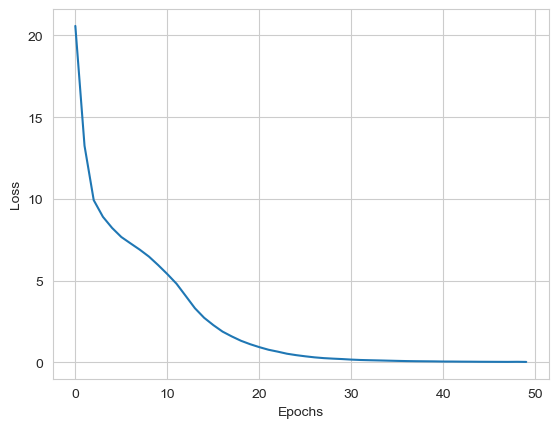

In [15]:
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Evaluate the model

In [16]:
examples = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 
            'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))

for example in examples:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: utils.to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0, 1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00], verbose=0)
    prediction = np.argmax(prediction, axis=-1)
    output = [inv_machine_vocab[int(np.squeeze(i)[()])] for i in prediction]
    
    print("Source date:", example)
    print("Output date:", ''.join(output), "\n")

Source date: 3 May 1979
Output date: 1979-05-03 

Source date: 5 April 09
Output date: 2009-04-05 

Source date: 21th of August 2016
Output date: 2016-08-10 

Source date: Tue 10 Jul 2007
Output date: 2007-06-10 

Source date: Saturday May 9 2018
Output date: 2018-05-09 

Source date: March 3 2001
Output date: 2001-03-03 

Source date: March 3rd 2001
Output date: 2001-03-03 

Source date: 1 March 2001
Output date: 2001-03-01 

